In [18]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib




In [19]:
df = pd.read_csv(r"dataset (1).csv")

In [20]:
df['trans_date_trans_time'] = pd.to_datetime(df["trans_date_trans_time"])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [21]:
drop_columns = ['Unnamed: 0','trans_date_trans_time','first','last',
               'street','city','state','zip','dob','job','trans_num']
df = df.drop(columns=drop_columns)

In [22]:
cat_col = ['merchant','category','gender']
encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])


In [23]:
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])
df['distance'] = haversine(df['lat'],df['long'],df['merch_lat'],df['merch_long'])

In [24]:
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x=df[features]
y = df['is_fraud']

In [25]:
import seaborn as sns

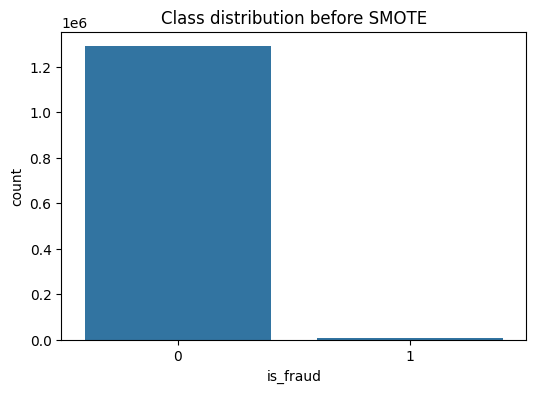

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud',data=df)
plt.title("Class distribution before SMOTE")
plt.show()

In [27]:
smote = SMOTE(random_state=42)
x_resample,y_resample = smote.fit_resample(x,y)

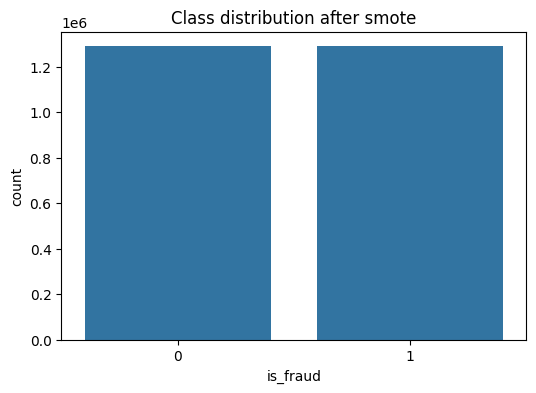

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class distribution after smote")
plt.show()

In [29]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size=0.2,random_state=42)

In [30]:
lgb_model = lgb.LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metrics = 'auc',
    is_unbalance = True,
    learning_rate = 0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [31]:
y_pred = lgb_model.predict(x_test)

In [32]:
print("Classification_Report:\n",classification_report(y_test,y_pred))
print("Roc AUC Score:",roc_auc_score(y_test,y_pred))

Classification_Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88    257186
           1       0.95      0.79      0.86    258482

    accuracy                           0.87    515668
   macro avg       0.88      0.87      0.87    515668
weighted avg       0.88      0.87      0.87    515668

Roc AUC Score: 0.8705875259208415


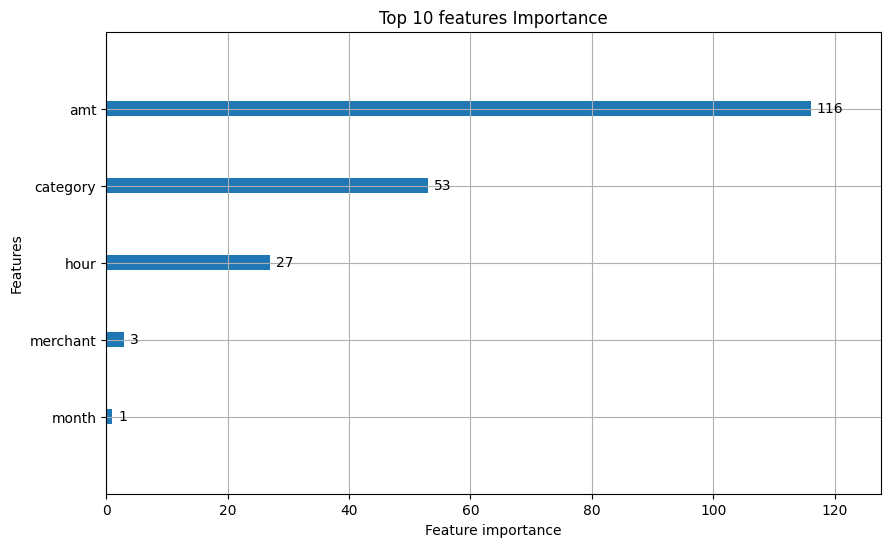

In [34]:
lgb.plot_importance(lgb_model,max_num_features=10,importance_type='split',figsize=(10,6))
plt.title("Top 10 features Importance")
plt.show()

In [36]:
fpr, tpr, thresholds = roc_curve(y_test,lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr,tpr)

In [37]:
joblib.dump(lgb_model,"fraud_detection_model.jb")
joblib.dump(encoders,"label_encoders.jb")

['label_encoders.jb']